# Deep Learning (with `torch`)

In [1]:
import numpy as np
import pandas as pd
import torch
from functools import partial
from tqdm import tqdm

In [2]:
# configure matplotlib output
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
bool_mean = lambda x: x.to(dtype=torch.float).mean()
get_scalar = lambda x: x.detach().item()

## Simple Neural Network

In [6]:
# simple hyperplane model
dim = 100
true_beta0 = 0.0
true_beta1 = 1.0*torch.ones(dim)

In [7]:
# make dataset and loader
N = 10000
space = torch.randn(N, dim)
rando = torch.tensor(np.random.logistic(size=N))
categ = (true_beta0 + space @ true_beta1 + rando > 0).to(dtype=torch.long)
dataset = torch.utils.data.TensorDataset(space, categ)
dataload = torch.utils.data.DataLoader(dataset, batch_size=1000)

In [8]:
# same neural as a module
bce_loss = torch.nn.CrossEntropyLoss()
class Neural(torch.nn.Module):
    def __init__(self, hid=2):
        super().__init__()
        self.linear0 = torch.nn.Linear(dim, hid)
        self.linear1 = torch.nn.Linear(hid, 2)
    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.linear1(x)
        return x

In [9]:
def neural_stats(logits, y):
    predict = logits[:, 1] >= logits[:, 0]
    target = y == 1
    return torch.tensor([
        bool_mean(predict == target),
        bool_mean(predict & ~target),
        bool_mean(~predict & target),
    ])

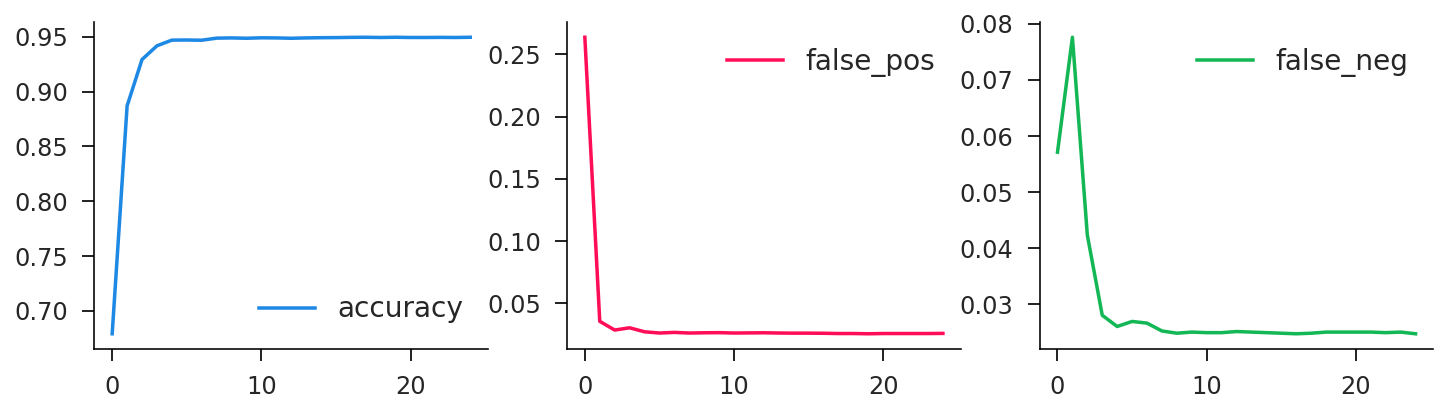

In [10]:
# make model and optimizer
model = Neural()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

# track history
history = []

# go for many iterations
for i in range(25):
    # accumulate stats per batch
    nbatch = 0
    stats = torch.zeros(3)

    # iterate over batches
    for x, y in dataload:
        # compute loss
        logits = model(x)
        loss = bce_loss(logits, y)

        # update params
        optim.zero_grad()
        loss.backward()
        optim.step()

        # add batch stats
        nbatch += 1
        stats += neural_stats(logits.detach(), y)

    # make it a mean    
    stats /= nbatch
    history.append(stats)

# turn history into dataframe
history = pd.DataFrame(
    torch.stack(history).numpy(),
    columns=['accuracy', 'false_pos', 'false_neg']
)
history.plot(subplots=True, layout=(1, 3), figsize=(12, 3));

## Overfitting

In [11]:
# parameters
N = 1000 # number of training series
M = 100 # number of validation series
T = 10 # total time length
L = 4 # sequence length
K = T - L # number of subseries

In [12]:
# generate overlapping sequences
def generate_sequences(vec, l):
    n, t = vec.shape
    k = t - l
    series = torch.stack([vec[:, i:i+l] for i in range(k)], axis=-1)
    series = series.transpose(1, 2).reshape((n*k, -1))
    target = vec[:, l:].reshape((n*k,))
    return series, target

In [13]:
# simple neural trader (long only)
class NeuralTrader(torch.nn.Module):
    def __init__(self, lag=4, hid=5):
        super().__init__()
        self.linear0 = torch.nn.Linear(lag, hid)
        self.linear1 = torch.nn.Linear(hid, 1)
    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x.squeeze()

In [14]:
def neural_trader(model, train_data, valid_data, lr=0.01, epochs=25, batch_size=1000):
    # make data loaders
    train_load = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_x, valid_y = valid_data.tensors

    # make model and optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # track history
    history = []

    # go for many iterations
    for i in tqdm(range(epochs)):
        n_batch = 0
        train_stats = torch.zeros(2)
        
        # iterate over batches
        model.train()
        for batch_x, batch_y in train_load:
            # compute loss
            recom = model(batch_x)
            retvrn = recom*batch_y
            loss = -retvrn.mean()

            # update params
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # training stats
            n_batch += 1
            train_stats += torch.tensor([recom.detach().mean(), retvrn.detach().mean()])

        # average training
        train_stats /= n_batch

        # validation stats
        model.eval()
        valid_recom = model(valid_x)
        valid_retvrn = valid_recom*valid_y
        valid_stats = torch.tensor([valid_recom.detach().mean(), valid_retvrn.detach().mean()])

        # make it a mean
        stats = torch.cat([train_stats, valid_stats])
        history.append(stats)

    # turn history into dataframe
    names = ['train_recom', 'train_return', 'valid_recom', 'valid_return']
    return pd.DataFrame(torch.stack(history).numpy(), columns=names)

### Random Returns

In [15]:
# generate training data
train_random_return = torch.randn(N, T)
train_random_series, train_random_target = generate_sequences(train_random_return, L)
train_random_data = torch.utils.data.TensorDataset(train_random_series, train_random_target)

# generate validation data
valid_random_return = torch.randn(M, T)
valid_random_series, valid_random_target = generate_sequences(valid_random_return, L)
valid_random_data = torch.utils.data.TensorDataset(valid_random_series, valid_random_target)

100%|█████████████████████████████████████████| 500/500 [00:18<00:00, 26.88it/s]


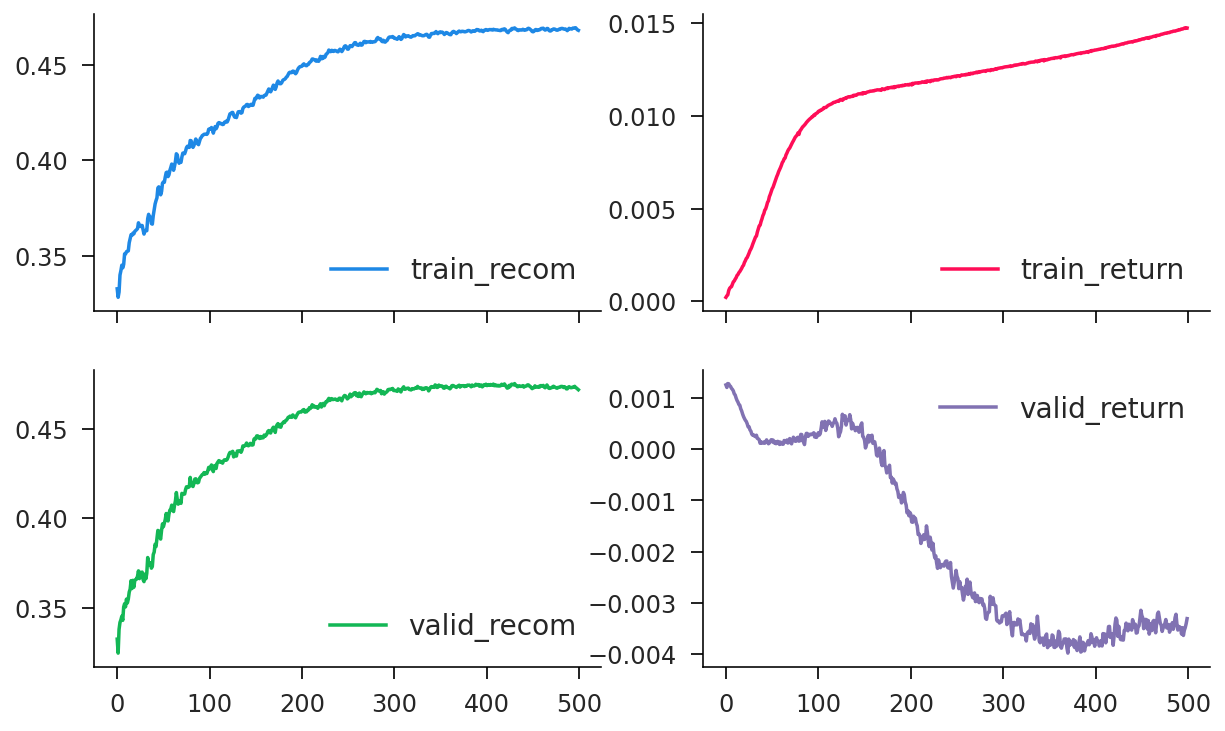

In [16]:
model_base = NeuralTrader(lag=L, hid=5)
history = neural_trader(model_base, train_random_data, valid_random_data, epochs=500)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

## With Momentum

In [17]:
momentum = 0.2

In [18]:
# generate training data
train_moment_mean = momentum*torch.randn(N)
train_moment_return = train_moment_mean[:, None] + torch.randn(N, T)
train_moment_series, train_moment_target = generate_sequences(train_moment_return, L)
train_moment_data = torch.utils.data.TensorDataset(train_moment_series, train_moment_target)

# generate validation data
valid_moment_mean = momentum*torch.randn(N)
valid_moment_return = valid_moment_mean[:, None] + torch.randn(N, T)
valid_moment_series, valid_moment_target = generate_sequences(valid_moment_return, L)
valid_moment_data = torch.utils.data.TensorDataset(valid_moment_series, valid_moment_target)

100%|█████████████████████████████████████████| 500/500 [00:19<00:00, 25.69it/s]


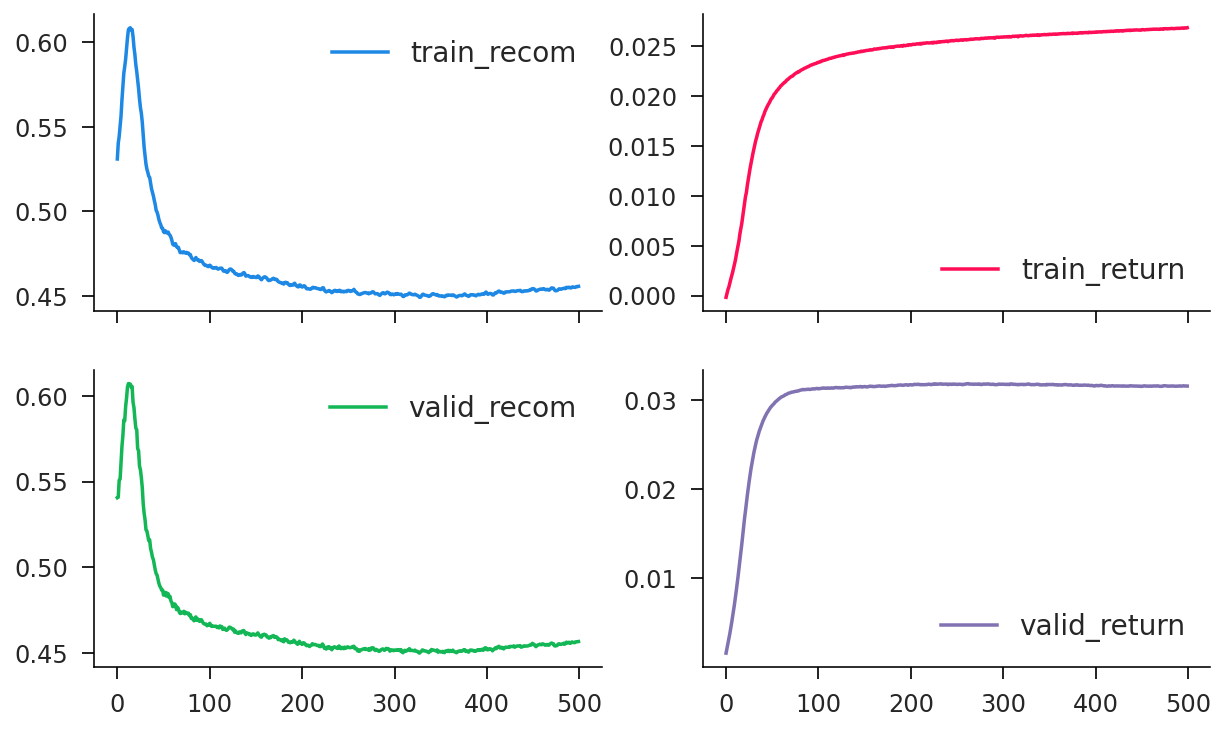

In [19]:
model_moment = NeuralTrader(lag=L, hid=5)
history = neural_trader(model_moment, train_moment_data, valid_moment_data, epochs=500)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

## Dropout

In [20]:
# simple neural trader (long only)
class DropoutTrader(torch.nn.Module):
    def __init__(self, lag=4, hid=5, drop=0.5):
        super().__init__()
        self.linear0 = torch.nn.Linear(lag, hid)
        self.linear1 = torch.nn.Linear(hid, 1)
        self.dropout = torch.nn.Dropout(drop)
        self.drop = drop
    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.dropout(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x.squeeze()

100%|█████████████████████████████████████████| 500/500 [00:22<00:00, 22.71it/s]


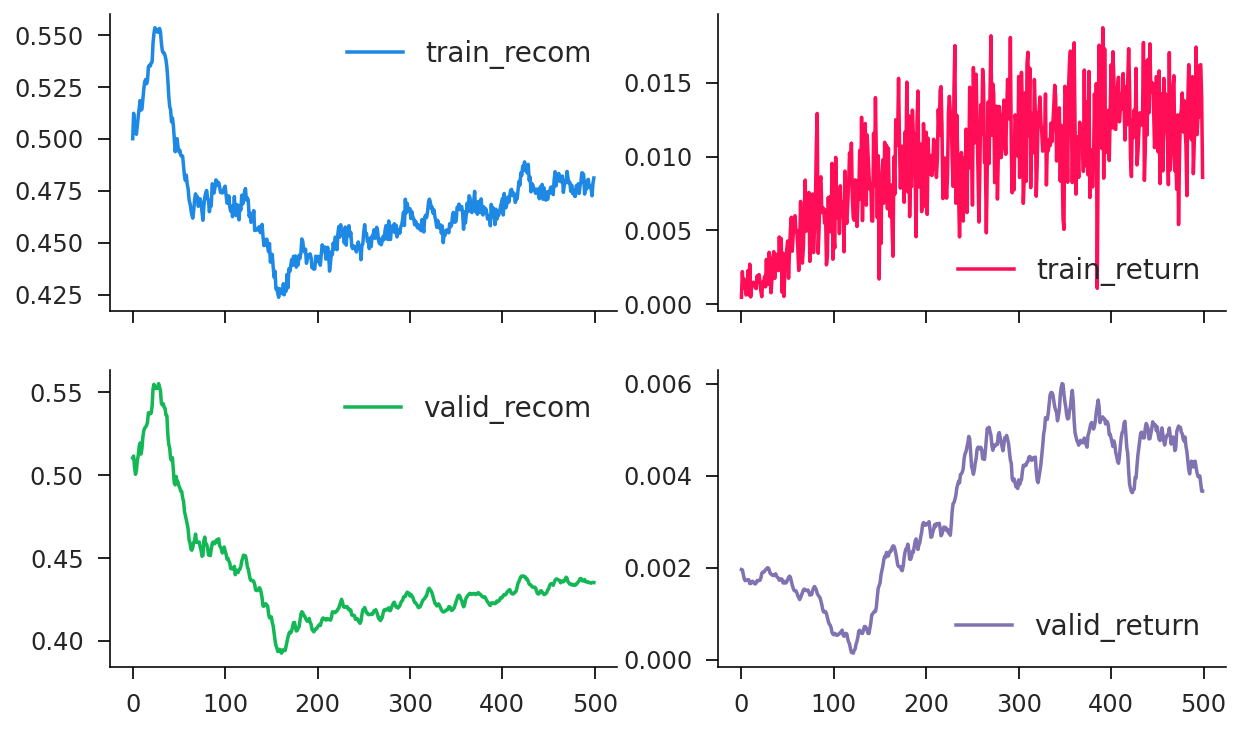

In [21]:
model_random_dropout = DropoutTrader(lag=L, hid=5, drop=0.5)
history = neural_trader(model_random_dropout, train_random_data, valid_random_data, epochs=500)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

100%|█████████████████████████████████████████| 500/500 [00:21<00:00, 23.14it/s]


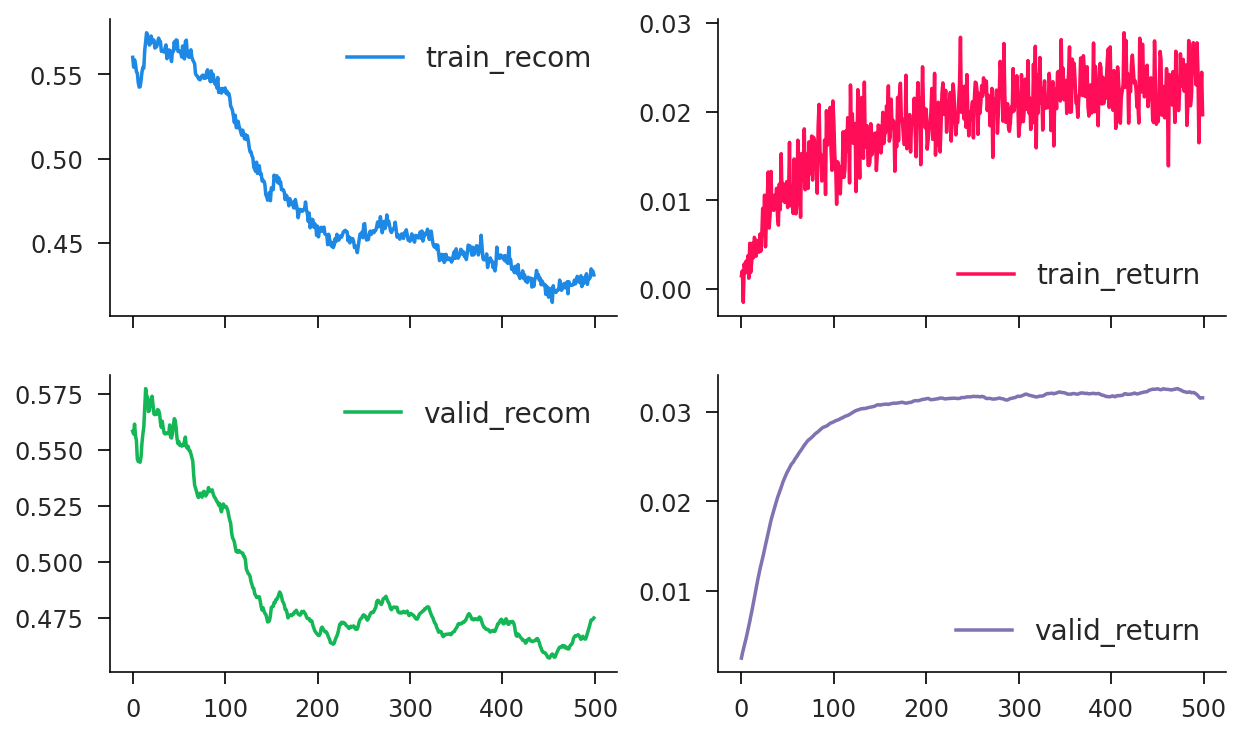

In [22]:
model_moment_dropout = DropoutTrader(lag=L, hid=5, drop=0.5)
history = neural_trader(model_moment_dropout, train_moment_data, valid_moment_data, epochs=500)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));